In [47]:
%pylab
%matplotlib inline
import skimage as sk
import skimage.io
import skvideo
import skvideo.io
import torch
import torch as T
import scipy
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import normalize
from tqdm import tqdm
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pad', 'shape', 'dtype', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
directory = "/home/ubuntu/"
# filename = "20180410_1.mp4"
filename = "20180109_2.mp4"
vid_gen = skvideo.io.vreader(directory+filename)

In [3]:
for frame in vid_gen:
    firstFrame = frame
    break

n = 20
frames = np.zeros([n,*frame.shape]).astype(np.uint8)
f = 0
# get some frames over time 
for i,frame in enumerate(vid_gen):
    if f >= n:
        break
    elif i % 1000 == 0:
        frames[f] = frame
        f+=1

vid_gen = skvideo.io.vreader(directory+filename)

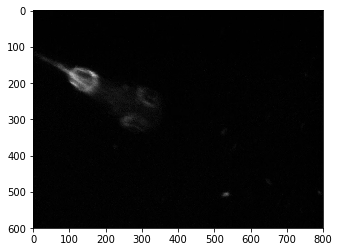

In [4]:
plt.imshow(firstFrame)

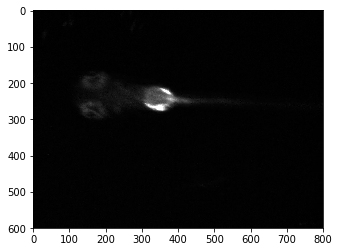

In [5]:
# find a good frame for ROI
plt.imshow(frames[11])

# ROI selection

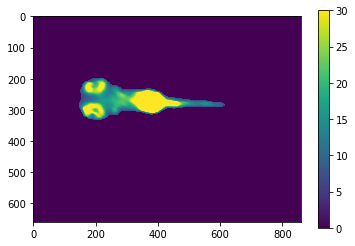

In [6]:
pad = 30
maxThreshold = 30
minThreshold = 7

frame = np.full([pad*2+firstFrame.shape[0],pad*2+firstFrame.shape[1]], 1)
frame[pad:-pad,pad:-pad] = denoise_tv_chambolle(frames[11,:,:,0]).copy()*255
frame[frame>maxThreshold] = maxThreshold
frame[frame<minThreshold] = 0
plt.imshow(frame)
plt.colorbar()

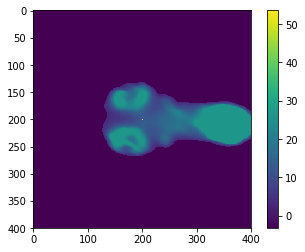

In [7]:
fishCenter = (pad+235,pad+190)
pad = 200

fishROI = frame[fishCenter[0]-pad:fishCenter[0]+pad,fishCenter[1]-pad:fishCenter[1]+pad]

# fishROI = normalize(fishROI, norm='l2')
fishROI = fishROI - fishROI.mean()
# fishROI = (fishROI - fishROI.mean())/fishROI.std()
# fishROI = fishROI - fishROI.sum()/len(fishROI)
fishROI = fishROI.astype(float32)

fishROI[pad,pad] = np.max(fishROI)*2
plt.imshow(fishROI)
plt.colorbar()
imageW, imageH = firstFrame.shape[:-1]

# Filter construction

In [8]:
def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[1], pivot[1]]
    padY = [img.shape[0] - pivot[0], pivot[0]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = scipy.ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

def ROI_to_filters(img, center, pad, imageW, imageH, nfilters=8, fft=False, dtype=np.float32):
    filter_size = 2*pad
    # we will use the center of the img plus a pad to create rotationally invariant filters
    filters = np.zeros([nfilters,filter_size,filter_size]).astype(np.float64)
    norm = (img - img.mean()).astype(np.float64) # subtract mean
    for i in range(nfilters):
        # rotate the image first around the provided pivot
        rot = rotateImage(norm, i * 360 / nfilters, center)
        # select the ROI for the filter
        filters[i] = rot[center[0]-pad:center[0]+pad,center[1]-pad:center[1]+pad]
        
    if fft:
        complex_filters = T.cuda.FloatTensor(nfilters,imageW, imageH, 2).zero_()
        complex_filters[:,0:filter_size,0:filter_size,0] = T.from_numpy(filters)
        return T.fft(complex_filters,2)
    else:
        return T.from_numpy(filters.astype(dtype)).cuda()

In [9]:
dtype = np.float32
filters = ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 8,dtype=dtype)
filters_fft = ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 8, fft=True)

IndexError: index 8 is out of bounds for dimension 0 with size 8

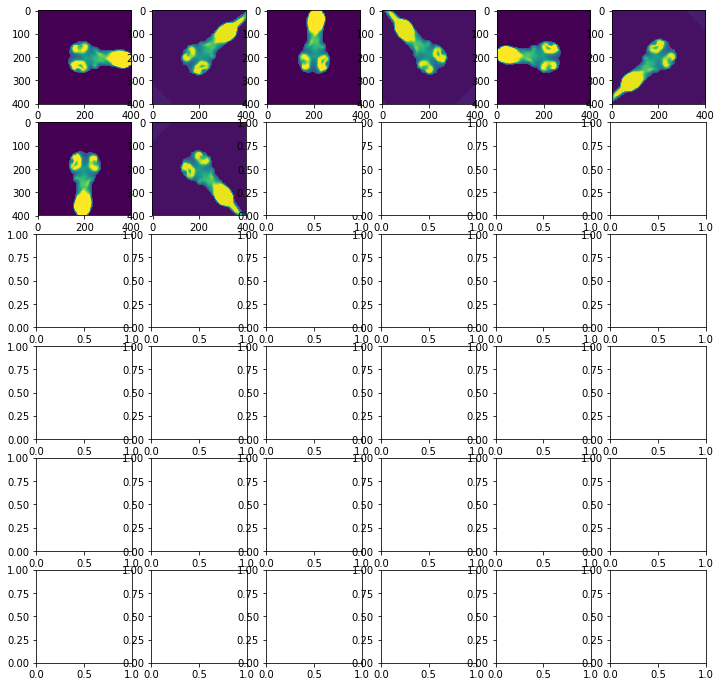

In [10]:
plt.subplots(6,6,figsize=(12,12))
for i in range(32):
    plt.subplot(6,6,1+i)
    plt.imshow(filters[i].cpu().numpy().astype(np.float32))

In [11]:
img = firstFrame[:,:,0].astype(dtype)

# Tracking code

In [12]:
def heatmap_fft(img, w, shape):
    fimg = T.cuda.FloatTensor(*w.shape[1:]).zero_()
    fimg[:,:,0] = T.from_numpy(img).cuda()
    conv = T.ifft(T.fft(fimg,2)*w,2)
    return conv[:,:,:,0]

def heatmap(img, w, shape):
    fimg = T.from_numpy(img).cuda()
    pad = (int((w.shape[1])/2),int((w.shape[2])/2))
    conv = F.conv2d(fimg[None,None,:,:,], w[:,None],padding=pad)
    return conv[0,:,:,:]


def find_position_fft(img, w, shape):
    fimg = T.cuda.FloatTensor(*w.shape[1:]).zero_()
    fimg[:,:,0] = T.from_numpy(img).cuda()
    conv = T.ifft(T.fft(fimg,2)*w,2)
    idx = conv.argmax()
    return np.unravel_index(idx, shape)[1:3]

def find_position(img, w):
    fimg = T.from_numpy(img).cuda()
    pad = (int((w.shape[1]-1)/2),int((w.shape[2]-1)/2))
    conv = F.conv2d(fimg[None,None,:,:,], w[:,None],padding=pad)
    idx = int(conv.argmax())
    y, x = np.unravel_index(idx, conv.shape)[2:]
    return y, x

def find_position_threshold(img, w, minThreshold=0,maxThreshold=20):
    fimg = T.from_numpy(img).cuda()
    fimg[fimg>maxThreshold] = maxThreshold
    fimg[fimg<minThreshold] = 0
    pad = (int((w.shape[1]-1)/2),int((w.shape[2]-1)/2))
    conv = F.conv2d(fimg[None,None,:,:,], w[:,None],padding=pad)
    idx = int(conv.argmax())
    y, x = np.unravel_index(idx, conv.shape)[2:]
    return y, x


def find_position_fft_np_argmax(img, w, shape):
    fimg = T.cuda.FloatTensor(*w.shape[1:]).zero_()
    fimg[:,:,0] = T.from_numpy(img).cuda()
    conv = T.ifft(T.fft(fimg,2)*w,2)
    idx = conv[:,:,:,0].cpu().numpy().argmax()
    return np.unravel_index(idx, shape)[1:3]

shape = [1, filters.shape[0],*img.shape]

# Benchmarking

In [13]:
%%timeit -r 3 -n 3
pos = heatmap_fft(img,filters_fft,shape)

1.24 ms ± 242 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [14]:
%%timeit -r 3 -n 3
# for some reason, pytorch argmax is performing very slowly.
pos = find_position_fft(img,filters_fft,shape)

ValueError: index 4796638 is out of bounds for array with size 3840000

In [15]:
%%timeit -r 3 -n 3
# numpy's argmax is performing much better, but this is suboptimal
# as must transfer entire image back to CPU
pos = find_position_fft_np_argmax(img,filters_fft,shape)

6.33 ms ± 132 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [121]:
%%timeit -r 3 -n 3
pos = heatmap(img,filters,shape)

465 ms ± 81.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [16]:
%%timeit -r 3 -n 3
pos = find_position(img,filters)

584 ms ± 6.33 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [31]:
img8 = img.astype(np.uint8)
filters8 = filters.byte()

In [59]:
def heatmap(img, w, shape):
    fimg = T.from_numpy(img).cuda()
    pad = (int((w.shape[1])/2),int((w.shape[2])/2))
    conv = F.conv2d(fimg[None,None,:,:,], w[:,None])
#     conv = F.conv2d(fimg[None,None,:,:,], w[:,None])
    return conv[0,:,:,:]

class Net(nn.Module):
    def __init__(self,c,kernel):
        super(Net, self).__init__()
        pad = (int((kernel[0])/2),int((kernel[1])/2))
        self.conv2d = nn.Conv2d(1,c,kernel)

    def forward(self, x):
        x = self.conv2d(x[None,None])
        return x[0,:,:,:]

model = Net(8,filters.shape[1:])
model.cuda()
fimg = T.from_numpy(img).cuda()
ITERS = 100

torch.cuda.synchronize()
start = time.time()
for i in range(ITERS):
    model(fimg)
# pos = heatmap(img,filters,shape)
torch.cuda.synchronize()
print("Time / iteration: ", (time.time()-start)/ITERS)

model = Net(8,filters.shape[1:])
model.cuda().half()
fimg = T.from_numpy(img16).cuda()
torch.cuda.synchronize()
start = time.time()
for i in range(ITERS):
    model(fimg)
# pos = heatmap(img16,filters16,shape)
torch.cuda.synchronize()
print("Time / iteration: ", (time.time()-start)/ITERS)

Time / iteration:  0.08381131887435914
Time / iteration:  0.08409387588500977


In [60]:
T.version.cuda

'9.0.176'

In [33]:
T.from_numpy(img16).dtype

torch.float16

In [25]:
%%timeit -r 3 -n 3
pos = heatmap(img16,filters16,shape)

439 ms ± 71.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [19]:
filters.dtype

torch.float32

In [18]:
%%timeit -r 3 -n 3
pos = find_position_threshold(img,filters)

873 ms ± 5.94 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


# FFT conv validation (failing)

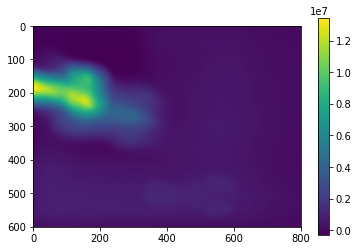

In [123]:
plt.imshow(heatmap(img, filters, shape).cpu().numpy()[0].astype(np.float64))
plt.colorbar()

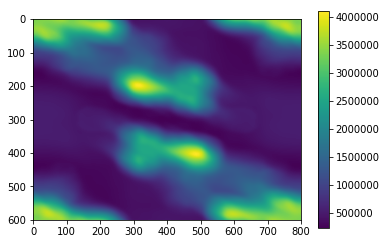

In [124]:
plt.imshow(heatmap_fft(img, filters_fft, shape)[0])
plt.colorbar()

# Create tracking video

In [ ]:
def drawROI(img, y, x, width=20,dot=1):
    colorimg = img.copy()
    colorimg[y-dot:y+dot,x-dot:x+dot] = [0,255,0]

    ystart = max(0,y-width)
    yend = min(img.shape[0]-1,y+width)
    xstart = max(0,x-width)
    xend = min(img.shape[1]-1,x+width)
    colorimg[ystart:yend,xstart] = [255,0,0]
    colorimg[ystart:yend,xend] = [255,0,0]
    colorimg[ystart,xstart:xend] = [255,0,0]
    colorimg[yend,xstart:xend] = [255,0,0]
    return colorimg

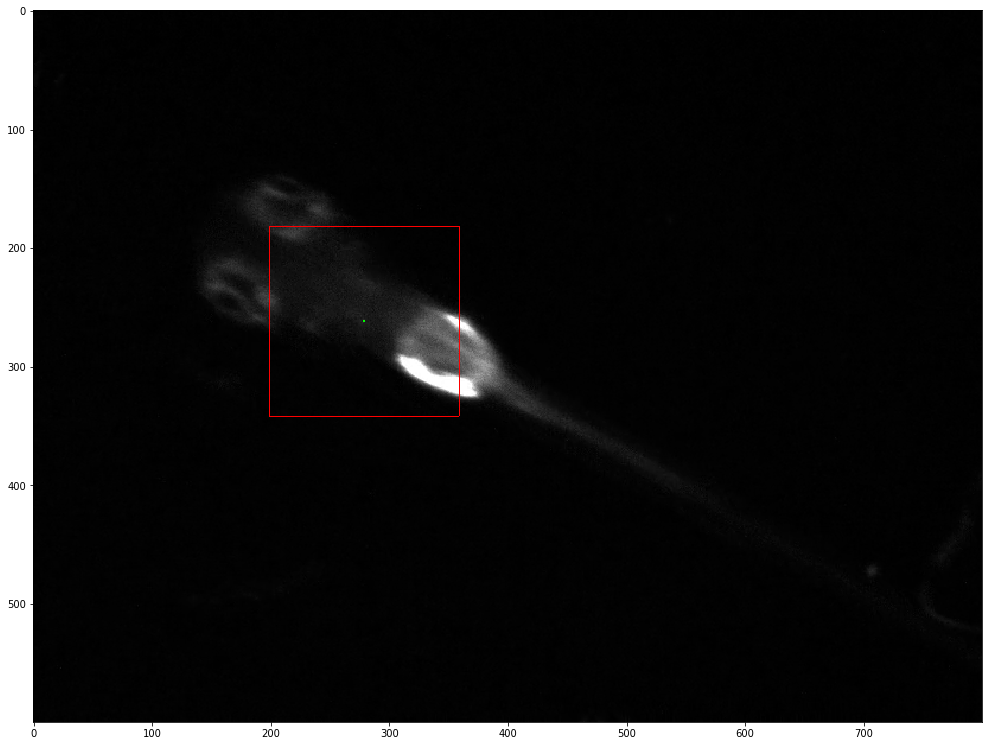

In [43]:
pos = find_position_threshold(img,filters)
plt.figure(figsize=(17,17))
plt.imshow(drawROI(frames[7],*pos,80))

In [18]:
writer = skvideo.io.FFmpegWriter(directory + "track_close_32filters_" + filename)
for t, frame in tqdm(enumerate(vid_gen)):
    if t % 10 ==0:
        img = frame[:,:,0].astype(np.float32)
        pos = find_position(img,filters)
        f = drawROI(frame,*pos,80)
        writer.writeFrame(f)
    if t > 1000*10:
        break
writer.close()


0it [00:00, ?it/s]
1it [00:00,  1.02it/s]

RuntimeError: 